Assignment - 19
----------------
Name : Nihar Kanungo, Shiv, Bhoomika, Manjunath 

Background :
--------------
Generative Adversarial Networks belong to the set of generative models. It means that they are able to produce / to generate (we’ll see how) new content. Generative Adversarial Networks (GANs for short) have had a huge success since they were introduced in 2014 by Ian J. Goodfellow and co-authors in the article Generative Adversarial Nets.

Requirements :
-----------------

The Purpose of this assignment is to train any Generative Adverserial Network  to create 64x64 images of Indian Cars.

Environment:
---------------
Development - Colab GPU , Jupyter Notebook Repository : Github

Algorithm : 
-------------
DC GAN

The core idea is we use a convolutional neural network instead of a vanilla neural network at both discriminator and generator

Import all required libraries

In [1]:
import time
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, Reshape
from keras.layers import Flatten, BatchNormalization, Dense, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Using TensorFlow backend.


#Mount the Google drive to this notebook.
We will read images from google drive and save the models and generated images in there

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
import cv2

from sklearn.model_selection import train_test_split

# Add the path to the notebook

In [0]:
path=os.path.join('gdrive','My Drive','indian_car')
path

'gdrive/My Drive/indian_car'

# This function loads the dataset into the notebook . These images are to be used for training the DCGAN

In [0]:
def load_dataset(dataset_path, batch_size, image_shape):
    dataset_generator = ImageDataGenerator()
    print(dataset_path, image_shape)
    dataset_generator = dataset_generator.flow_from_directory(
        dataset_path, target_size=(image_shape[0], image_shape[1]),
        batch_size=batch_size,
        class_mode=None)
    print(dataset_generator)
    return dataset_generator

# Define the custom loss function 

which will penalize more . This would help to generate better images 

In [0]:
from tensorflow.keras.losses import categorical_crossentropy
import tensorflow_probability as tfp
import tensorflow as tf
from tensorflow.keras import backend as K

class custom_loss:
  
  def get_L2_enhanced_loss(model):
    conv_layers = [layer for layer in model.layers if type(layer)==Conv2DTranspose and layer.trainable_weights[0].shape.as_list()[0]>0]
    conv_layers = conv_layers[:-1]
    def L2_enhanced():
      total_loss = K.variable(0)
      for layer in conv_layers:
        weights = layer.trainable_weights[0]
        total_loss = total_loss + tf.nn.l2_loss(weights)
      return total_loss
    return L2_enhanced



  def get_combined_L2_cross_entropy_loss(model,alpha,batch_size,total_data_size,
                                        epochs, end_percentage=0.1, scale=100):
    l2_loss = custom_loss.get_L2_enhanced_loss(model, )
    iters_per_epoch = int(np.ceil(total_data_size/batch_size))
    num_iterations = epochs*iters_per_epoch
    mid_cycle_id = int(num_iterations * ((1. - end_percentage)) / float(2))
    container ={"iterations":0}
    sess = K.get_session()



    def combined_loss(y_true, y_pred):
      container['iterations'] = container['iterations'] + 1
      iterations = container['iterations']

      # new_alpha = lr_momentum_decider.min_max_scaler(iterations, num_iterations, end_percentage, alpha/scale, alpha, invert = False)

      new_alpha = alpha

      loss = categorical_crossentropy(y_true, y_pred) + new_alpha * l2_loss()
      return loss
    return combined_loss

# Creates the discriminator model.
This model tries to classify images as real or fake.

Discriminator is a kind of oracle that knows exactly what are the true and generated distribution and that is able, based on this information, to predict a class (“true” or “generated”) for any given point. If the two distributions are far appart, the discriminator will be able to classify easily and with a high level of confidence most of the points we present to it. If we want to fool the discriminator, we have to bring the generated distribution close to the true one. The discriminator will have the most difficulty to predict the class when the two distributions will be equal in all points: in this case, for each point there are equal chances for it to be “true” or “generated” and then the discriminator can’t do better than being true in one case out of two in average.

In [0]:
# Creates the discriminator model. This model tries to classify images as real
# or fake.
def construct_discriminator(image_shape):

    discriminator = Sequential()
    discriminator.add(Conv2D(filters=64, kernel_size=(5, 5),
                             strides=(2, 2), padding='same',
                             data_format='channels_last',
                             kernel_initializer='glorot_uniform',
                             input_shape=(image_shape)))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Conv2D(filters=128, kernel_size=(5, 5),
                             strides=(2, 2), padding='same',
                             data_format='channels_last',
                             kernel_initializer='glorot_uniform'))
    discriminator.add(BatchNormalization(momentum=0.5))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Conv2D(filters=256, kernel_size=(5, 5),
                             strides=(2, 2), padding='same',
                             data_format='channels_last',
                             kernel_initializer='glorot_uniform'))
    discriminator.add(BatchNormalization(momentum=0.5))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Conv2D(filters=512, kernel_size=(5, 5),
                             strides=(2, 2), padding='same',
                             data_format='channels_last',
                             kernel_initializer='glorot_uniform'))
    discriminator.add(BatchNormalization(momentum=0.5))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Flatten())
    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))

    optimizer = Adam(lr=0.0002, beta_1=0.5)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=None)

    return discriminator

# Define Generative models 

Suppose that we are interested in generating black and white square images of dogs with a size of n by n pixels. We can reshape each data as a N=nxn dimensional vector (by stacking columns on top of each others) such that an image of dog can then be represented by a vector. However, it doesn’t mean that all vectors represent a dog once shaped back to a square! So, we can say that the N dimensional vectors that effectively give something that look like a dog are distributed according to a very specific probability distribution over the entire N dimensional vector space (some points of that space are very likely to represent dogs whereas it is highly unlikely for some others). In the same spirit, there exists, over this N dimensional vector space, probability distributions for images of cats, birds and so on.

In [0]:
# Creates the generator model. This model has an input of random noise and
# generates an image that will try mislead the discriminator.
def construct_generator():

    generator = Sequential()

    generator.add(Dense(units=4 * 4 * 512,
                        kernel_initializer='glorot_uniform',
                        input_shape=(1, 1, 100)))
    generator.add(Reshape(target_shape=(4, 4, 512)))
    generator.add(BatchNormalization(momentum=0.5))
    generator.add(Activation('relu'))

    generator.add(Conv2DTranspose(filters=256, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same',
                                  data_format='channels_last',
                                  kernel_initializer='glorot_uniform'))
    generator.add(BatchNormalization(momentum=0.5))
    generator.add(Activation('relu'))

    generator.add(Conv2DTranspose(filters=128, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same',
                                  data_format='channels_last',
                                  kernel_initializer='glorot_uniform'))
    generator.add(BatchNormalization(momentum=0.5))
    generator.add(Activation('relu'))

    generator.add(Conv2DTranspose(filters=64, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same',
                                  data_format='channels_last',
                                  kernel_initializer='glorot_uniform'))
    generator.add(BatchNormalization(momentum=0.5))
    generator.add(Activation('relu'))

    generator.add(Conv2DTranspose(filters=3, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same',
                                  data_format='channels_last',
                                  kernel_initializer='glorot_uniform'))
    generator.add(Activation('tanh'))

    

    optimizer = Adam(lr=0.00015, beta_1=0.5)
    # generator.compile(loss='binary_crossentropy',
    #                   optimizer=optimizer,
    #                   metrics=None)

    generator.compile(loss=custom_loss.get_combined_L2_cross_entropy_loss(generator,5e-4,16,128, epochs=650, end_percentage=0.05),
               optimizer=optimizer,
               metrics=['accuracy'])

    return generator


This function saves the images generated

In [0]:
# Displays a figure of the generated images and saves them in as .png image
def save_generated_images(generated_images, epoch, batch_number):

    plt.figure(figsize=(8, 8), num=2)
    gs1 = gridspec.GridSpec(8, 8)
    gs1.update(wspace=0, hspace=0)

    for i in range(32):
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        image = generated_images[i, :, :, :]
        image += 1
        image *= 127.5
        fig = plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

    plt.tight_layout()
    save_name = 'gdrive/My Drive/indian_car/generated_images/generatedSamples_epoch' + str(
        epoch + 1) + '_batch' + str(batch_number + 1) + '.png'

    plt.savefig(save_name, bbox_inches='tight', pad_inches=0)
    plt.pause(0.0000000001)
    if epoch/200 == 0:
      plt.show()

![alt text](images/initial.png)

a generative network G(.) that takes a random input z with density p_z and returns an output x_g = G(z) that should follow (after training) the targeted probability distribution a discriminative network D(.) that takes an input x that can be a “true” one (x_t, whose density is denoted p_t) or a “generated” one (x_g, whose density p_g is the density induced by the density p_z going through G) and that returns the probability D(x) of x to be a “true” data Let’s take now a closer look at the “theoretical” loss function of GANs. If we send to the discriminator “true” and “generated” data in the same proportions, the expected absolute error of the discriminator can then be expressed as 

![alt text](images/formula.png)

The goal of the generator is to fool the discriminator whose goal is to be able to distinguish between true and generated data. So, when training the generator, we want to maximise this error while we try to minimise it for the discriminator.

In order to better understand why training a generator to fool a discriminator will lead to the same result as training directly the generator to match the target distribution, let’s take a simple one dimensional example. We forget, for the moment, how both generator and discriminator are represented and consider them as abstract notions (that will be specified in the next subsection). Moreover, both are supposed “perfect” (with infinite capacities) in the sense that they are not constrained by any kind of (parametrised) model.

In [0]:
# Main train function
def train_dcgan(batch_size, epochs, image_shape, dataset_path):
    # Build the adversarial model that consists in the generator output
    # connected to the discriminator
    generator = construct_generator()
    discriminator = construct_discriminator(image_shape)

    gan = Sequential()
    # Only false for the adversarial model
    discriminator.trainable = False
    gan.add(generator)
    gan.add(discriminator)

    optimizer = Adam(lr=0.00015, beta_1=0.5)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer,
                metrics=None)

    # Create a dataset Generator with help of keras
    dataset_generator = load_dataset(dataset_path, batch_size, image_shape)

    # 11788 is the total number of images on the bird dataset
    number_of_batches = int(394 / batch_size)

    # Variables that will be used to plot the losses from the discriminator and
    # the adversarial models
    adversarial_loss = np.empty(shape=1)
    discriminator_loss = np.empty(shape=1)
    batches = np.empty(shape=1)

    # Allo plot updates inside for loop
    plt.ion()

    current_batch = 0

    # Let's train the DCGAN for n epochs
    for epoch in range(epochs):

        print("Epoch " + str(epoch+1) + "/" + str(epochs) + " :")

        for batch_number in range(number_of_batches):

            start_time = time.time()

            # Get the current batch and normalize the images between -1 and 1
            real_images = dataset_generator.next()
            real_images /= 127.5
            real_images -= 1

            # The last batch is smaller than the other ones, so we need to
            # take that into account
            current_batch_size = real_images.shape[0]

            # Generate noise
            noise = np.random.normal(0, 1,
                                     size=(current_batch_size,) + (1, 1, 100))

            # Generate images
            generated_images = generator.predict(noise)

            # Add some noise to the labels that will be
            # fed to the discriminator
            real_y = (np.ones(current_batch_size) -
                      np.random.random_sample(current_batch_size) * 0.2)
            fake_y = np.random.random_sample(current_batch_size) * 0.2

            # Let's train the discriminator
            discriminator.trainable = True

            d_loss = discriminator.train_on_batch(real_images, real_y)
            d_loss += discriminator.train_on_batch(generated_images, fake_y)

            discriminator_loss = np.append(discriminator_loss, d_loss)

            # Now it's time to train the generator
            discriminator.trainable = False

            noise = np.random.normal(0, 1,
                                     size=(current_batch_size * 2,) +
                                     (1, 1, 100))

            # We try to mislead the discriminator by giving the opposite labels
            fake_y = (np.ones(current_batch_size * 2) -
                      np.random.random_sample(current_batch_size * 2) * 0.2)

            g_loss = gan.train_on_batch(noise, fake_y)
            adversarial_loss = np.append(adversarial_loss, g_loss)
            batches = np.append(batches, current_batch)

            # Each 50 batches show and save images
            if((batch_number + 1) % 12 == 0 and
               current_batch_size == batch_size) and epoch % 100 == 0:
                save_generated_images(generated_images, epoch, batch_number)

            time_elapsed = time.time() - start_time

            # Display and plot the results
            print("     Batch " + str(batch_number + 1) + "/" +
                  str(number_of_batches) +
                  " generator loss | discriminator loss : " +
                  str(g_loss) + " | " + str(d_loss) + ' - batch took ' +
                  str(time_elapsed) + ' s.')

            current_batch += 1

        # Save the model weights each 5 epochs
        if (epoch + 1) % 100 == 0:
            discriminator.trainable = True
            generator.save('gdrive/My Drive/indian_car/models/generator_epoch' + str(epoch) + '.hdf5')
            discriminator.save('gdrive/My Drive/indian_car/models/discriminator_epoch' +
                               str(epoch) + '.hdf5')

        # Each epoch update the loss graphs
        if epoch %100 == 0:
          plt.figure(1)
          plt.plot(batches, adversarial_loss, color='green',
                  label='Generator Loss')
          plt.plot(batches, discriminator_loss, color='blue',
                  label='Discriminator Loss')
          plt.title("DCGAN Train")
          plt.xlabel("Batch Iteration")
          plt.ylabel("Loss")
          if epoch == 0:
              plt.legend()
          plt.pause(0.0000000001)
          if epoch % 100 ==0:
            plt.show()
            plt.savefig('trainingLossPlot.png')
        if np.mod(g_loss , d_loss) < 0.1:
          epoch = epochs


# Execute the model using the hyper parameters 

gdrive/My Drive/indian_car
gdrive/My Drive/indian_car












Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
gdrive/My Drive/indian_car (64, 64, 3)
Found 394 images belonging to 9 classes.
Epoch 1/10000 :


     Batch 1/12 generator loss | discriminator loss : 4.569808 | 6.391795 - batch took 23.224825620651245 s.
     Batch 2/12 generator loss | discriminator loss : 5.4430075 | 1.400202 - batch took 12.863862037658691 s.
     Batch 3/12 generator loss | discriminator loss : 12.431841 | 2.2671523 - batch took 14.602152347564697 s.
     Batch 4/12 generator loss | discriminator loss : 6.0489225 | 5.065732 - batch took 13.506158113479614 s.
     Batch 5/12 generator loss | discriminator loss : 9.048019 | 6.346126 - batch took 13.435041189193726 s.
     Batch 6/12 generator loss | discriminator loss : 9.859209 | 1.8944818 - batch took 15.05727505683899 s.
  

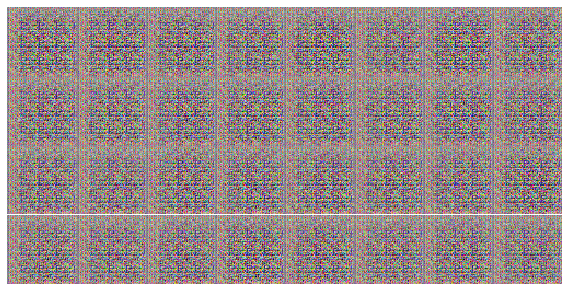

     Batch 12/12 generator loss | discriminator loss : 14.304636 | 1.9886856 - batch took 14.79823088645935 s.


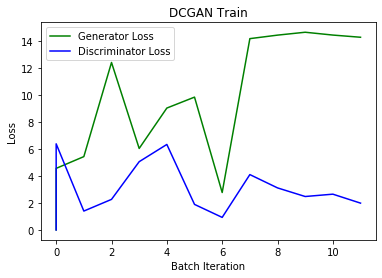

Epoch 2/10000 :
     Batch 1/12 generator loss | discriminator loss : 14.397595 | 2.1365578 - batch took 4.605845212936401 s.
     Batch 2/12 generator loss | discriminator loss : 14.35578 | 2.0447047 - batch took 0.1281287670135498 s.
     Batch 3/12 generator loss | discriminator loss : 14.526617 | 2.4189117 - batch took 0.1280956268310547 s.
     Batch 4/12 generator loss | discriminator loss : 14.597392 | 2.3713632 - batch took 0.127532958984375 s.
     Batch 5/12 generator loss | discriminator loss : 14.44166 | 2.1433747 - batch took 0.12779664993286133 s.
     Batch 6/12 generator loss | discriminator loss : 14.443984 | 1.9542408 - batch took 0.12450885772705078 s.
     Batch 7/12 generator loss | discriminator loss : 14.372146 | 2.2286127 - batch took 0.12842893600463867 s.
     Batch 8/12 generator loss | discriminator loss : 14.577996 | 2.141442 - batch took 0.12682485580444336 s.
     Batch 9/12 generator loss | discriminator loss : 14.634931 | 1.9014769 - batch took 0.122991

<Figure size 432x288 with 0 Axes>

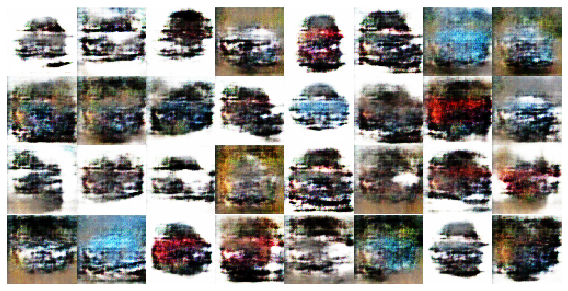

     Batch 12/12 generator loss | discriminator loss : 2.1030722 | 0.6834025 - batch took 1.3002922534942627 s.


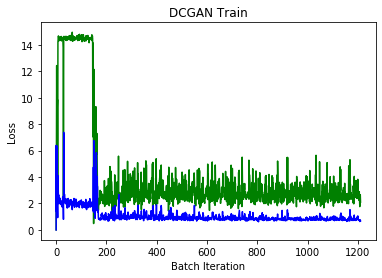

Epoch 102/10000 :
     Batch 1/12 generator loss | discriminator loss : 3.2496347 | 0.7849052 - batch took 0.13930559158325195 s.
     Batch 2/12 generator loss | discriminator loss : 2.3176715 | 0.74427253 - batch took 0.14153766632080078 s.
     Batch 3/12 generator loss | discriminator loss : 2.5781248 | 0.8193681 - batch took 0.1334080696105957 s.
     Batch 4/12 generator loss | discriminator loss : 2.5971808 | 0.7194164 - batch took 0.13580846786499023 s.
     Batch 5/12 generator loss | discriminator loss : 3.1150591 | 0.7249819 - batch took 0.13174676895141602 s.
     Batch 6/12 generator loss | discriminator loss : 1.8861346 | 0.76991093 - batch took 0.12979507446289062 s.
     Batch 7/12 generator loss | discriminator loss : 4.627674 | 0.94449097 - batch took 0.1294724941253662 s.
     Batch 8/12 generator loss | discriminator loss : 2.4860787 | 1.1001878 - batch took 0.13051724433898926 s.
     Batch 9/12 generator loss | discriminator loss : 2.5945492 | 0.8731097 - batch to

<Figure size 432x288 with 0 Axes>

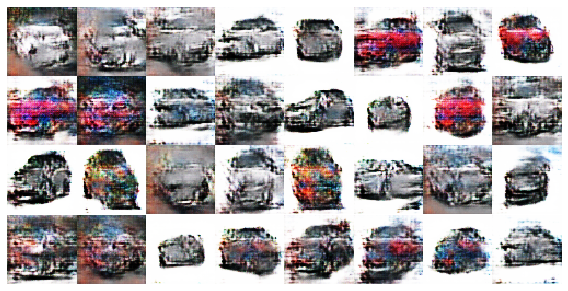

     Batch 12/12 generator loss | discriminator loss : 2.3706164 | 0.7159085 - batch took 1.419161319732666 s.


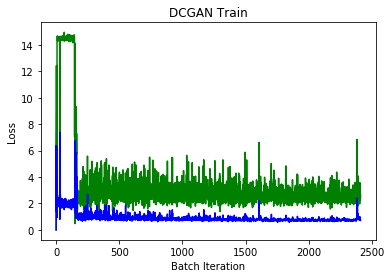

Epoch 202/10000 :
     Batch 1/12 generator loss | discriminator loss : 2.9261541 | 0.8251358 - batch took 0.14009332656860352 s.
     Batch 2/12 generator loss | discriminator loss : 2.6500533 | 0.8537701 - batch took 0.14148640632629395 s.
     Batch 3/12 generator loss | discriminator loss : 3.0999846 | 0.7602708 - batch took 0.13639140129089355 s.
     Batch 4/12 generator loss | discriminator loss : 2.5792813 | 0.8063288 - batch took 0.13733267784118652 s.
     Batch 5/12 generator loss | discriminator loss : 3.1864831 | 0.8174254 - batch took 0.13413739204406738 s.
     Batch 6/12 generator loss | discriminator loss : 2.6370971 | 0.83506095 - batch took 0.06659483909606934 s.
     Batch 7/12 generator loss | discriminator loss : 3.6640584 | 1.0233722 - batch took 0.1374654769897461 s.
     Batch 8/12 generator loss | discriminator loss : 2.2390828 | 1.0034049 - batch took 0.1269059181213379 s.
     Batch 9/12 generator loss | discriminator loss : 2.8755465 | 0.8095968 - batch too

<Figure size 432x288 with 0 Axes>

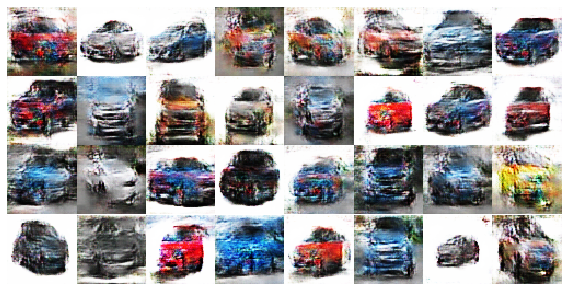

     Batch 12/12 generator loss | discriminator loss : 1.7735901 | 0.8152037 - batch took 1.2926437854766846 s.


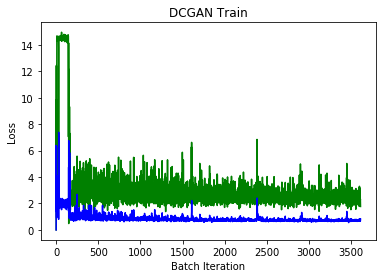

Epoch 302/10000 :
     Batch 1/12 generator loss | discriminator loss : 3.2224698 | 0.7622231 - batch took 0.1333482265472412 s.
     Batch 2/12 generator loss | discriminator loss : 2.2978668 | 0.9256046 - batch took 0.06304168701171875 s.
     Batch 3/12 generator loss | discriminator loss : 2.6628397 | 0.8245914 - batch took 0.12775015830993652 s.
     Batch 4/12 generator loss | discriminator loss : 2.458786 | 0.70826685 - batch took 0.13173389434814453 s.
     Batch 5/12 generator loss | discriminator loss : 2.1745625 | 0.755386 - batch took 0.1348576545715332 s.
     Batch 6/12 generator loss | discriminator loss : 2.4255712 | 0.69515175 - batch took 0.13022994995117188 s.
     Batch 7/12 generator loss | discriminator loss : 2.2230115 | 0.64187735 - batch took 0.12400150299072266 s.
     Batch 8/12 generator loss | discriminator loss : 2.1628776 | 0.7025223 - batch took 0.1284654140472412 s.
     Batch 9/12 generator loss | discriminator loss : 2.3115988 | 0.65732497 - batch too

<Figure size 432x288 with 0 Axes>

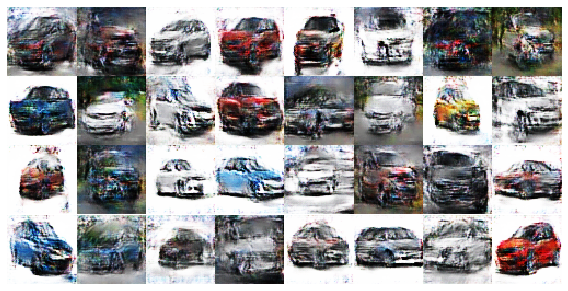

     Batch 12/12 generator loss | discriminator loss : 3.2100286 | 0.8006152 - batch took 1.4540104866027832 s.


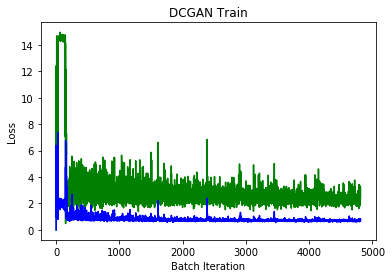

Epoch 402/10000 :
     Batch 1/12 generator loss | discriminator loss : 2.8866727 | 0.8218585 - batch took 0.14075398445129395 s.
     Batch 2/12 generator loss | discriminator loss : 2.088618 | 0.6717262 - batch took 0.13766264915466309 s.
     Batch 3/12 generator loss | discriminator loss : 2.5256019 | 0.66804063 - batch took 0.13640403747558594 s.
     Batch 4/12 generator loss | discriminator loss : 2.2739515 | 0.7606304 - batch took 0.14864206314086914 s.
     Batch 5/12 generator loss | discriminator loss : 2.3537955 | 0.8077309 - batch took 0.13643383979797363 s.
     Batch 6/12 generator loss | discriminator loss : 2.2789435 | 0.71780145 - batch took 0.1368086338043213 s.
     Batch 7/12 generator loss | discriminator loss : 2.4478874 | 0.7201405 - batch took 0.13432621955871582 s.
     Batch 8/12 generator loss | discriminator loss : 2.029219 | 0.78760713 - batch took 0.14018011093139648 s.
     Batch 9/12 generator loss | discriminator loss : 2.5176983 | 0.71071494 - batch t

<Figure size 432x288 with 0 Axes>

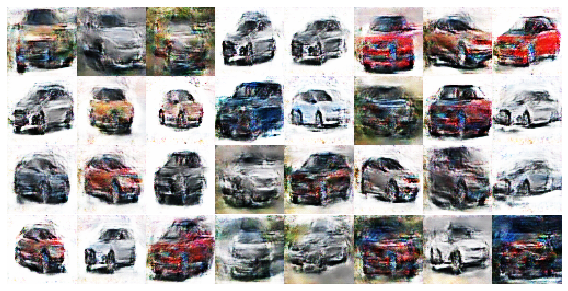

     Batch 12/12 generator loss | discriminator loss : 2.1725593 | 0.6543529 - batch took 1.3183090686798096 s.


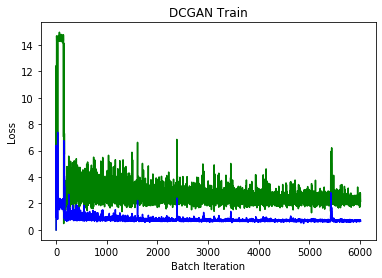

Epoch 502/10000 :
     Batch 1/12 generator loss | discriminator loss : 1.9873734 | 0.7395574 - batch took 0.13391542434692383 s.
     Batch 2/12 generator loss | discriminator loss : 2.8036058 | 0.67730665 - batch took 0.1375744342803955 s.
     Batch 3/12 generator loss | discriminator loss : 2.5929773 | 0.71099985 - batch took 0.1330568790435791 s.
     Batch 4/12 generator loss | discriminator loss : 2.1024256 | 0.62061495 - batch took 0.1394810676574707 s.
     Batch 5/12 generator loss | discriminator loss : 2.1925707 | 0.7252319 - batch took 0.13292884826660156 s.
     Batch 6/12 generator loss | discriminator loss : 2.2912989 | 0.6454309 - batch took 0.1247873306274414 s.
     Batch 7/12 generator loss | discriminator loss : 1.370427 | 0.7033712 - batch took 0.06400132179260254 s.
     Batch 8/12 generator loss | discriminator loss : 2.4648345 | 0.7865155 - batch took 0.1242978572845459 s.
     Batch 9/12 generator loss | discriminator loss : 2.3725748 | 0.6600214 - batch took 

<Figure size 432x288 with 0 Axes>

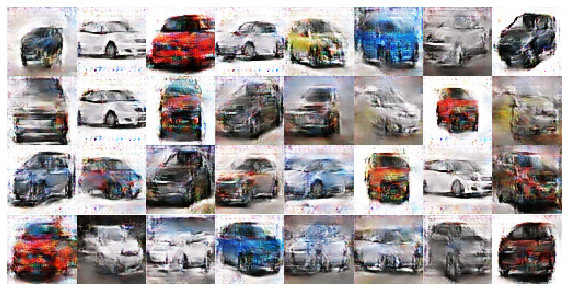

     Batch 12/12 generator loss | discriminator loss : 2.4542122 | 0.68477654 - batch took 1.463672161102295 s.


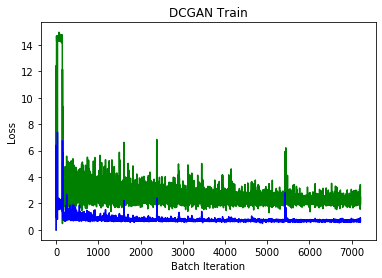

Epoch 602/10000 :
     Batch 1/12 generator loss | discriminator loss : 2.7768059 | 0.6998036 - batch took 0.1510334014892578 s.
     Batch 2/12 generator loss | discriminator loss : 2.0291963 | 0.6738032 - batch took 0.1285243034362793 s.
     Batch 3/12 generator loss | discriminator loss : 2.239874 | 0.6783241 - batch took 0.06491494178771973 s.
     Batch 4/12 generator loss | discriminator loss : 2.3852763 | 0.63744485 - batch took 0.13149523735046387 s.
     Batch 5/12 generator loss | discriminator loss : 2.3093643 | 0.67953706 - batch took 0.13669705390930176 s.
     Batch 6/12 generator loss | discriminator loss : 2.38057 | 0.69106996 - batch took 0.13153553009033203 s.
     Batch 7/12 generator loss | discriminator loss : 2.166779 | 0.7177398 - batch took 0.13300228118896484 s.
     Batch 8/12 generator loss | discriminator loss : 2.2492228 | 0.6503365 - batch took 0.1315171718597412 s.
     Batch 9/12 generator loss | discriminator loss : 2.4231758 | 0.6427461 - batch took 0

<Figure size 432x288 with 0 Axes>

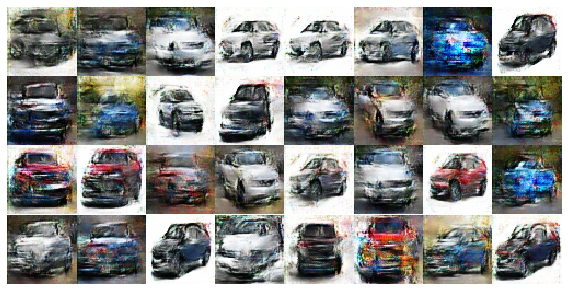

     Batch 12/12 generator loss | discriminator loss : 2.3600953 | 0.6917989 - batch took 1.2401940822601318 s.


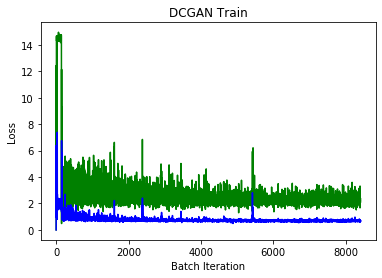

Epoch 702/10000 :
     Batch 1/12 generator loss | discriminator loss : 2.0208573 | 0.69157195 - batch took 0.14236116409301758 s.
     Batch 2/12 generator loss | discriminator loss : 2.2881343 | 0.66506755 - batch took 0.128143310546875 s.
     Batch 3/12 generator loss | discriminator loss : 2.0596313 | 0.69195545 - batch took 0.13285565376281738 s.
     Batch 4/12 generator loss | discriminator loss : 1.9856822 | 0.6918335 - batch took 0.13152337074279785 s.
     Batch 5/12 generator loss | discriminator loss : 2.0314503 | 0.6660116 - batch took 0.13476037979125977 s.
     Batch 6/12 generator loss | discriminator loss : 2.33835 | 0.6516442 - batch took 0.12750697135925293 s.
     Batch 7/12 generator loss | discriminator loss : 2.199704 | 0.65041393 - batch took 0.12983441352844238 s.
     Batch 8/12 generator loss | discriminator loss : 2.059508 | 0.6702082 - batch took 0.13200020790100098 s.
     Batch 9/12 generator loss | discriminator loss : 2.6535597 | 0.6549233 - batch took

<Figure size 432x288 with 0 Axes>

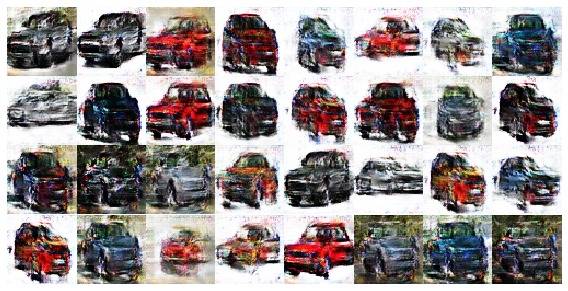

     Batch 12/12 generator loss | discriminator loss : 2.1070604 | 0.672439 - batch took 1.4671478271484375 s.


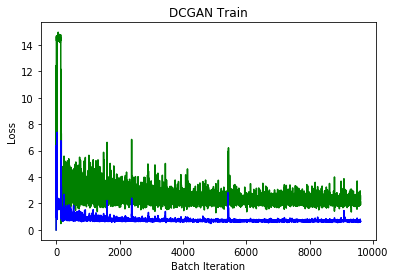

Epoch 802/10000 :
     Batch 1/12 generator loss | discriminator loss : 2.1852655 | 0.6648484 - batch took 0.13695240020751953 s.
     Batch 2/12 generator loss | discriminator loss : 2.0998192 | 0.70593965 - batch took 0.1373767852783203 s.
     Batch 3/12 generator loss | discriminator loss : 2.5029159 | 0.6656873 - batch took 0.1343390941619873 s.
     Batch 4/12 generator loss | discriminator loss : 2.2740173 | 0.67080116 - batch took 0.13284945487976074 s.
     Batch 5/12 generator loss | discriminator loss : 2.3153052 | 0.64674103 - batch took 0.13450384140014648 s.
     Batch 6/12 generator loss | discriminator loss : 2.4393132 | 0.6794119 - batch took 0.1368262767791748 s.
     Batch 7/12 generator loss | discriminator loss : 2.1291091 | 0.6653912 - batch took 0.13641071319580078 s.
     Batch 8/12 generator loss | discriminator loss : 1.8993332 | 0.7315065 - batch took 0.06487560272216797 s.
     Batch 9/12 generator loss | discriminator loss : 2.1076388 | 0.6796473 - batch to

<Figure size 432x288 with 0 Axes>

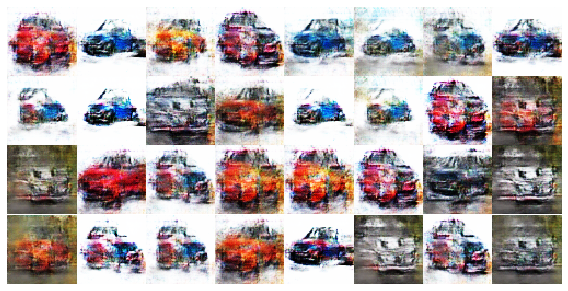

     Batch 12/12 generator loss | discriminator loss : 2.4183555 | 0.6186825 - batch took 1.2260069847106934 s.


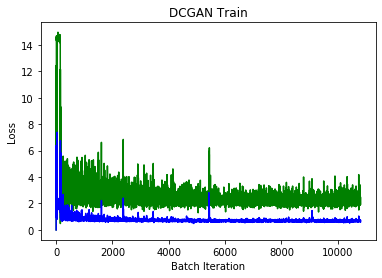

Epoch 902/10000 :
     Batch 1/12 generator loss | discriminator loss : 2.4462955 | 0.6632338 - batch took 0.13387537002563477 s.
     Batch 2/12 generator loss | discriminator loss : 2.1561167 | 0.6231798 - batch took 0.18764400482177734 s.
     Batch 3/12 generator loss | discriminator loss : 2.0796022 | 0.70996 - batch took 0.13713693618774414 s.
     Batch 4/12 generator loss | discriminator loss : 1.7071178 | 0.66291404 - batch took 0.06602239608764648 s.
     Batch 5/12 generator loss | discriminator loss : 2.3705285 | 0.6461245 - batch took 0.12525320053100586 s.
     Batch 6/12 generator loss | discriminator loss : 2.7401538 | 0.72871673 - batch took 0.13271760940551758 s.
     Batch 7/12 generator loss | discriminator loss : 2.0568511 | 0.64653575 - batch took 0.13069844245910645 s.
     Batch 8/12 generator loss | discriminator loss : 2.33701 | 0.75206137 - batch took 0.13503170013427734 s.
     Batch 9/12 generator loss | discriminator loss : 2.4994807 | 0.6626651 - batch to

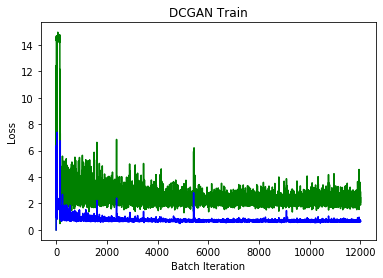

Epoch 1002/10000 :
     Batch 1/12 generator loss | discriminator loss : 2.1995318 | 0.7127391 - batch took 0.13338994979858398 s.
     Batch 2/12 generator loss | discriminator loss : 2.489559 | 0.60921013 - batch took 0.12989306449890137 s.
     Batch 3/12 generator loss | discriminator loss : 2.1928334 | 0.7010845 - batch took 0.1273195743560791 s.
     Batch 4/12 generator loss | discriminator loss : 2.558463 | 0.68004096 - batch took 0.13122797012329102 s.
     Batch 5/12 generator loss | discriminator loss : 2.25972 | 0.61333835 - batch took 0.13087034225463867 s.
     Batch 6/12 generator loss | discriminator loss : 2.1150274 | 0.65646374 - batch took 0.14060235023498535 s.
     Batch 7/12 generator loss | discriminator loss : 1.9140804 | 0.68572724 - batch took 0.12791991233825684 s.
     Batch 8/12 generator loss | discriminator loss : 2.513555 | 0.65458775 - batch took 0.13573837280273438 s.
     Batch 9/12 generator loss | discriminator loss : 2.740942 | 0.66729605 - batch t

In [0]:
print(path)
dataset_path = path
print(dataset_path)
batch_size = 32
image_shape = (64, 64, 3)
epochs = 10000
train_dcgan(batch_size, epochs,image_shape, dataset_path)



Summary
-------
The above is unable to display all the images generated due to memory constraint. We will have the gif to show how it generated and corrects every images after every epoch .

The Genarated images are not completely as expected but very close to it. We may try to run it with the condiition to stop only when the accurcy are 50% each .

We will try to do so in our next attempt and see how it works

